# PART II:
### Testing the parameters obtained in Part I on the whole Polboks dataset.
Using the model created in the file "Part_I_Community_Detection_Polbooks.ipynb", I trained the whole Polbooks dataset. Unfortunately, only around half of the nodes were assigned correctly. The reason for that might be the fact that it was really hard to find some correct parameters for the GCN model.

However, the main goal of this experiment was to prove that the Deep Graph Library in general can be used to solve Community Detection Tasks. Even though my solution is not flawless, I am sure that with some better model the results will improve. All in all, I would recommend using this library for research purposes rather than in production environments. 

In [1]:
%matplotlib inline

In [2]:
import dgl
import numpy as np

In [3]:
try:  # Python 3.x
    import urllib.request as urllib
except ImportError:  # Python 2.x
    import urllib
import io
import zipfile

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx


In [4]:
url = "http://www-personal.umich.edu/~mejn/netdata/polbooks.zip"

sock = urllib.urlopen(url)
s = io.BytesIO(sock.read())
sock.close()

zf = zipfile.ZipFile(s)
txt = zf.read('polbooks.txt').decode()
gml = zf.read('polbooks.gml').decode()

gml = gml.split('\n')[1:]
g = nx.parse_gml(gml)

print(txt)
for node in g.nodes(data='value'):
    print(node)
    
NUMBER_OF_NODES = g.number_of_nodes()
NUMBER_OF_EDGES = g.number_of_edges()
print("\n Number of nodes: ", NUMBER_OF_NODES, " Number of edges: ", NUMBER_OF_EDGES)

Books about US politics
Compiled by Valdis Krebs

Nodes represent books about US politics sold by the online bookseller
Amazon.com.  Edges represent frequent co-purchasing of books by the same
buyers, as indicated by the "customers who bought this book also bought
these other books" feature on Amazon.

Nodes have been given values "l", "n", or "c" to indicate whether they are
"liberal", "neutral", or "conservative".  These alignments were assigned
separately by Mark Newman based on a reading of the descriptions and
reviews of the books posted on Amazon.

These data should be cited as V. Krebs, unpublished,
http://www.orgnet.com/.

('1000 Years for Revenge', 'n')
('Bush vs. the Beltway', 'c')
("Charlie Wilson's War", 'c')
('Losing Bin Laden', 'c')
('Sleeping With the Devil', 'n')
('The Man Who Warned America', 'c')
('Why America Slept', 'n')
('Ghost Wars', 'n')
('A National Party No More', 'c')
('Bush Country', 'c')
('Dereliction of Duty', 'c')
('Legacy', 'c')
('Off with Their Heads', '

In [5]:
LIBERAL = 0
CONSERVATIVE = 1
NEUTRAL = 2
CATEGORY_IDX = 1

In [6]:
CATEGORIES_MAPPING = {'l' : 0, 'c' : 1, 'n' : 2}
def map_categories_to_nums(graph_values):
    return [CATEGORIES_MAPPING[el[CATEGORY_IDX]] for el in graph_values]

In [7]:
COLORS_MAPPING = {LIBERAL: "blue", CONSERVATIVE: "red", NEUTRAL: "green"}
def map_categories_to_colors(categories_list):
    return [COLORS_MAPPING[el] for el in categories_list]

In [8]:
graph_values = g.nodes.data('value')
categorized_nodes = map_categories_to_nums(graph_values)

In [9]:
print(categorized_nodes)

[2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]


In [10]:
node_colors = map_categories_to_colors(categorized_nodes)

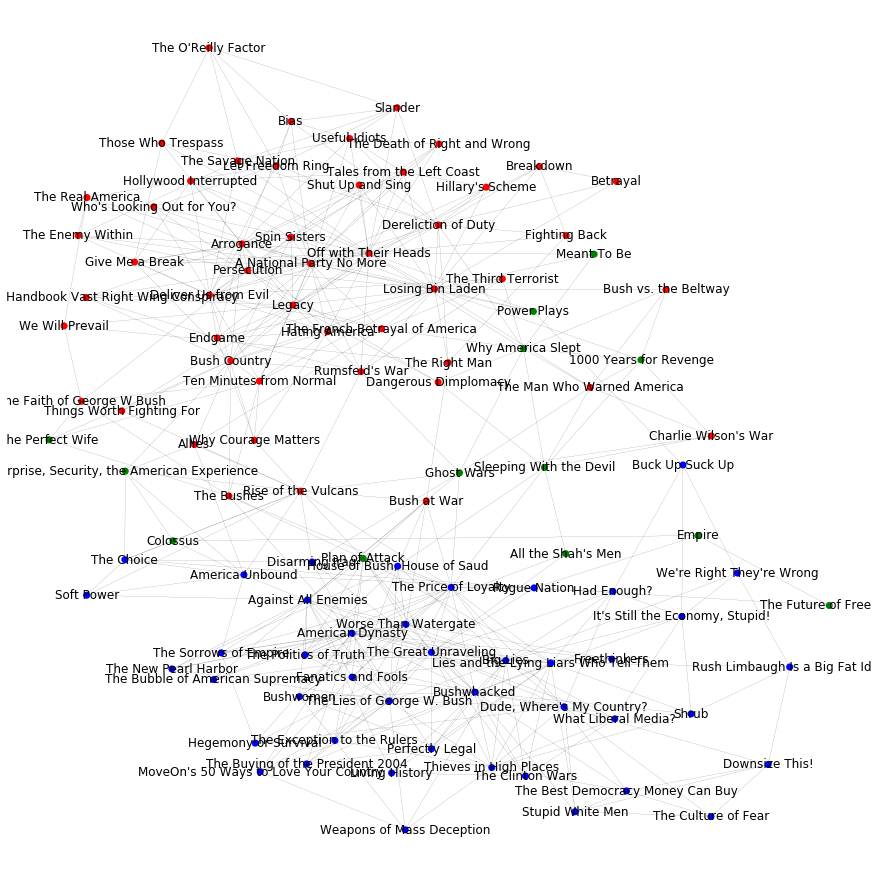

In [11]:
options = {
    'node_color':  node_colors,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels': True,
    'pos': nx.kamada_kawai_layout(g)
}
plt.figure(3,figsize=(12,12)) 
nx.draw(g, **options)
plt.show()

In [12]:
nx.is_directed(g)

False

In [13]:
G = dgl.DGLGraph()
G.from_networkx(g)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


embed = nn.Embedding(NUMBER_OF_NODES, 18)
G.ndata['feat'] = embed.weight

In [15]:
from dgl.nn.pytorch import GraphConv

In [16]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, hidden_size_1, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size_1)
        self.conv3 = GraphConv(hidden_size_1, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        h = self.conv3(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(18, 9, 6, 3)

In [17]:
def get_nodes_with_category(nodes, category):
    return [i for i, el in enumerate(nodes) if el == category]

In [18]:
liberal_nodes = get_nodes_with_category(categorized_nodes, LIBERAL)
conservative_nodes = get_nodes_with_category(categorized_nodes, CONSERVATIVE)
neutral_nodes = get_nodes_with_category(categorized_nodes, NEUTRAL)
print(len(liberal_nodes), len(conservative_nodes), len(neutral_nodes))

43 49 13


In [19]:
import random

def sample_n_nodes(dataset, n, category):
    books_within_category = get_nodes_with_category(dataset, category)
    
    random.shuffle(books_within_category)
    books_within_category = books_within_category[:n]
    labels = [category] * len(books_within_category)
    return torch.Tensor(books_within_category).long(), torch.Tensor(labels).long()

In [20]:
sample_liberal_nodes, sample_liberal_labels = sample_n_nodes(categorized_nodes, 15, LIBERAL)
sample_conservative_nodes, sample_conservative_labels = sample_n_nodes(categorized_nodes, 12, CONSERVATIVE)
sample_neutral_nodes, sample_neutral_labels = sample_n_nodes(categorized_nodes, 4, NEUTRAL)

In [21]:
inputs = embed.weight

labeled_nodes = torch.cat((sample_liberal_nodes, sample_conservative_nodes, sample_neutral_nodes), 0)
labels = torch.cat((sample_liberal_labels, sample_conservative_labels, sample_neutral_labels), 0)
print(labeled_nodes, labels)

tensor([ 30,  68,  71,  82,  73,  74,  83,  59,  65,  70,  86,  62,  31, 102,
        101,  39,   8,  36,  38,  45,  23,  77,  11,  22,  27,  21,  17, 103,
         46,   7,  76]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2])


In [22]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(80):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.1084
Epoch 1 | Loss: 1.0840
Epoch 2 | Loss: 1.0626
Epoch 3 | Loss: 1.0437
Epoch 4 | Loss: 1.0269
Epoch 5 | Loss: 1.0119
Epoch 6 | Loss: 0.9991
Epoch 7 | Loss: 0.9883
Epoch 8 | Loss: 0.9793
Epoch 9 | Loss: 0.9720
Epoch 10 | Loss: 0.9660
Epoch 11 | Loss: 0.9610
Epoch 12 | Loss: 0.9564
Epoch 13 | Loss: 0.9520
Epoch 14 | Loss: 0.9477
Epoch 15 | Loss: 0.9430
Epoch 16 | Loss: 0.9378
Epoch 17 | Loss: 0.9323
Epoch 18 | Loss: 0.9264
Epoch 19 | Loss: 0.9208
Epoch 20 | Loss: 0.9148
Epoch 21 | Loss: 0.9085
Epoch 22 | Loss: 0.9019
Epoch 23 | Loss: 0.8952
Epoch 24 | Loss: 0.8882
Epoch 25 | Loss: 0.8809
Epoch 26 | Loss: 0.8736
Epoch 27 | Loss: 0.8660
Epoch 28 | Loss: 0.8583
Epoch 29 | Loss: 0.8501
Epoch 30 | Loss: 0.8413
Epoch 31 | Loss: 0.8323
Epoch 32 | Loss: 0.8232
Epoch 33 | Loss: 0.8136
Epoch 34 | Loss: 0.8036
Epoch 35 | Loss: 0.7935
Epoch 36 | Loss: 0.7831
Epoch 37 | Loss: 0.7722
Epoch 38 | Loss: 0.7608
Epoch 39 | Loss: 0.7489
Epoch 40 | Loss: 0.7365
Epoch 41 | Loss: 0.7237
Ep

In [23]:
def draw(i):
    pos = {}
    colors = []
    classification= []
    for v in range(NUMBER_OF_NODES):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        classification.append(cls)
        colors.append(COLORS_MAPPING[cls])
    options = {
    'node_color':  colors,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels': True,
    'pos': nx.kamada_kawai_layout(g)
    }
    plt.figure(3,figsize=(12,12)) 
    nx.draw(g, **options)
    return classification

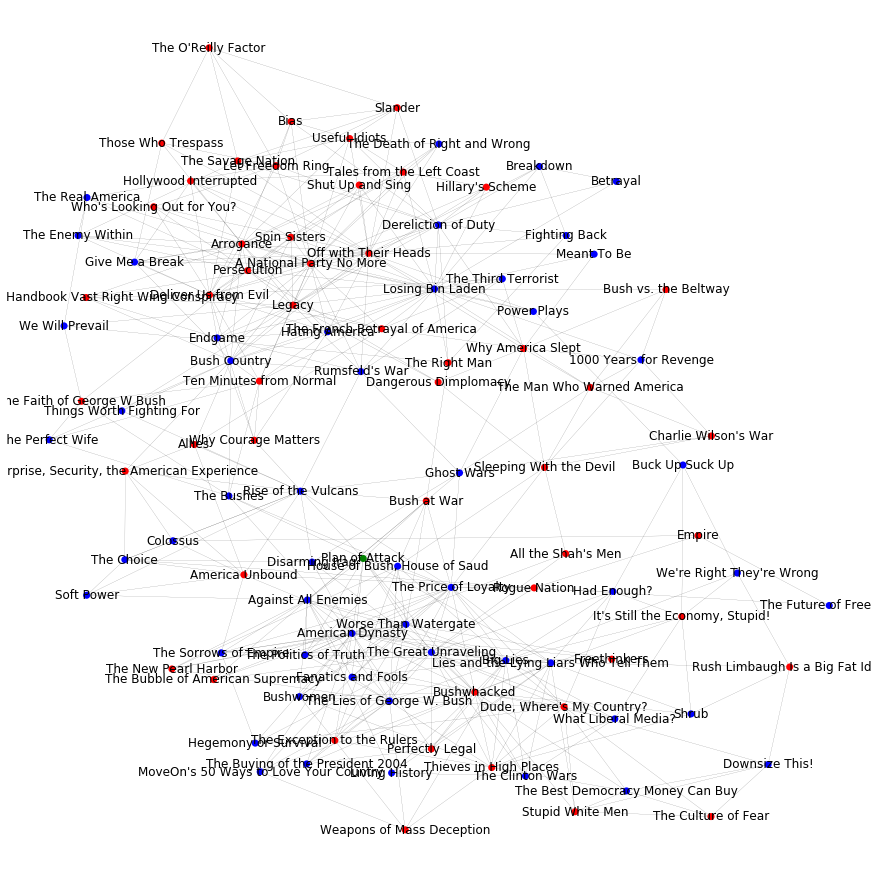

In [24]:
result = draw(79)

In [25]:
def print_correctly_assigned(categorized_nodes, result):
    from operator import sub
    correctly_assigned = list(map(sub, categorized_nodes, result)).count(0)
    print("Correctly assigned: " + str(correctly_assigned) + "/" + str(NUMBER_OF_NODES))

In [26]:
print_correctly_assigned(categorized_nodes, result)

Correctly assigned: 60/105
